In [143]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sklearn.model_selection import KFold

In [144]:
# Load data
Xtrain2_b = np.load('Xtrain2_b.npy')
Ytrain2_b = np.load('Ytrain2_b.npy')
Xtest2_b = np.load('Xtest2_b.npy')
# Check dimensions
print(Xtrain2_b.shape)
print(Ytrain2_b.shape)
print(Xtest2_b.shape)

(547, 2304)
(547, 2304)
(196, 2304)


In [183]:
sum(sum(sum(Ytrain2_b))), 48*48*547

(363859.0, 1260288)

In [180]:
for i in Ytrain2_b:
    print(sum(sum(i)), 48*48)

284.0 2304
658.0 2304
599.0 2304
473.0 2304
1163.0 2304
1109.0 2304
890.0 2304
583.0 2304
800.0 2304
1088.0 2304
306.0 2304
235.0 2304
379.0 2304
504.0 2304
303.0 2304
1233.0 2304
1087.0 2304
242.0 2304
528.0 2304
655.0 2304
653.0 2304
1069.0 2304
1038.0 2304
529.0 2304
353.0 2304
798.0 2304
309.0 2304
598.0 2304
522.0 2304
1354.0 2304
649.0 2304
1196.0 2304
899.0 2304
1124.0 2304
938.0 2304
472.0 2304
615.0 2304
789.0 2304
743.0 2304
1535.0 2304
525.0 2304
575.0 2304
1111.0 2304
529.0 2304
1272.0 2304
485.0 2304
328.0 2304
617.0 2304
275.0 2304
245.0 2304
453.0 2304
414.0 2304
546.0 2304
814.0 2304
1155.0 2304
1200.0 2304
807.0 2304
717.0 2304
361.0 2304
766.0 2304
236.0 2304
318.0 2304
446.0 2304
673.0 2304
524.0 2304
370.0 2304
564.0 2304
1225.0 2304
1357.0 2304
478.0 2304
653.0 2304
282.0 2304
1164.0 2304
1068.0 2304
994.0 2304
450.0 2304
503.0 2304
813.0 2304
269.0 2304
469.0 2304
486.0 2304
514.0 2304
704.0 2304
620.0 2304
1129.0 2304
440.0 2304
1628.0 2304
463.0 2304
556.0 2304


Preprocessing

In [145]:
print("Original unique values:", np.unique(Ytrain2_b))
Ytrain2_b = np.where(Ytrain2_b == 255, 1, Ytrain2_b)
print("Original unique values:", np.unique(Ytrain2_b))

Original unique values: [  0. 255.]
Original unique values: [0. 1.]


In [146]:
# Reshape data
Xtrain2_b = Xtrain2_b.reshape(547,48,48)
Ytrain2_b = Ytrain2_b.reshape(547,48,48)

# Scale data
train_images2_b = (Xtrain2_b).astype('float32')/255.0

In [147]:
Ytrain2_b[..., np.newaxis].shape

(547, 48, 48, 1)

In [177]:
for i in range(Ytrain2_b.shape[0]):
    if np.all(Ytrain2_b[i] != 1):
        print(i)

In [148]:
#Ytrain2_b = Ytrain2_b[..., np.newaxis]

Data split

In [149]:
# Split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(train_images2_b, Ytrain2_b, test_size=0.2)

In [150]:
y_train = y_train[..., np.newaxis]
y_val = y_val[..., np.newaxis]

Metric function

In [151]:
def balanced_accuracy(y_true, y_pred):
    # Convert logits to class predictions (0 or 1)
    y_pred = tf.round(tf.clip_by_value(y_pred, 0, 1))  # Round the predictions to get binary values
    
    # Compute confusion matrix components
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))  # True Positives
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))  # True Negatives
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))  # False Positives
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))  # False Negatives

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn + tf.keras.backend.epsilon())  # Avoid division by zero
    specificity = tn / (tn + fp + tf.keras.backend.epsilon())  # Avoid division by zero

    # Balanced Accuracy
    return (sensitivity + specificity) / 2  # Average of sensitivity and specificity

Set up model

In [196]:
def smaller_unet(input_shape):
    inputs = layers.Input(input_shape)
    
    # Encoder path (downsampling)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    drop1 = layers.Dropout(0.3)(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(drop1)  # Output size: 24x24
    
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    drop2 = layers.Dropout(0.3)(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(drop2)  # Output size: 12x12
    
    # Bottleneck
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    drop3 = layers.Dropout(0.3)(conv3)
    
    # Decoder path (upsampling)
    up4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(drop3)
    merge4 = layers.concatenate([conv2, up4], axis=3)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.3)(conv4)
    
    up5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(drop4)
    merge5 = layers.concatenate([conv1, up5], axis=3)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.3)(conv5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(drop5)
    
    model = Model(inputs, outputs)
    
    return model

input_shape = (48, 48, 1)
model = smaller_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', balanced_accuracy])
model.summary()

Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_280 (Conv2D) │ (None, 48, 48,    │        320 │ input_layer_31[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_281 (Conv2D) │ (None, 48, 48,    │      9,248 │ conv2d_280[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_95          │ (None, 48, 48,    │          0 │ conv2d_281[0][0]  │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_44    │ (None, 24, 24,    │          0 │ dropout_95[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 24, 24,    │     18,496 │ max_pooling2d_44… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_283 (Conv2D) │ (None, 24, 24,    │     36,928 │ conv2d_282[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_96          │ (None, 24, 24,    │          0 │ conv2d_283[0][0]  │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_45    │ (None, 12, 12,    │          0 │ dropout_96[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_284 (Conv2D) │ (None, 12, 12,    │     73,856 │ max_pooling2d_45… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 12, 12,    │    147,584 │ conv2d_284[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_97          │ (None, 12, 12,    │          0 │ conv2d_285[0][0]  │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_44 │ (None, 24, 24,    │     32,832 │ dropout_97[0][0]  │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_44      │ (None, 24, 24,    │          0 │ conv2d_283[0][0], │
│ (Concatenate)       │ 128)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 24, 24,    │     73,792 │ concatenate_44[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_287 (Conv2D) │ (None, 24, 24,    │     36,928 │ conv2d_286[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_98          │ (None, 24, 24,    │          0 │ conv2d_287[0][0]

 Total params: 483,393 (1.84 MB)

 Trainable params: 483,393 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

Train model

In [197]:
reduce_lr = ReduceLROnPlateau(monitor='val_balanced_accuracy', factor=0.5, patience=5, min_lr=1e-9)

early_stopping = EarlyStopping(monitor='val_balanced_accuracy', patience=20, restore_best_weights=True, mode='max')

#callbacks=[reduce_lr, metrics, early_stopping]

history = model.fit(X_train, y_train, batch_size=64,
                         epochs=100,
                         validation_data=(X_val, y_val),
                         callbacks=[reduce_lr, early_stopping],
                         verbose=1)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - accuracy: 0.7008 - balanced_accuracy: 0.5006 - loss: 0.6630 - val_accuracy: 0.7187 - val_balanced_accuracy: 0.5000 - val_loss: 0.6205 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - accuracy: 0.7095 - balanced_accuracy: 0.5000 - loss: 0.6228 - val_accuracy: 0.7187 - val_balanced_accuracy: 0.5000 - val_loss: 0.6076 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.7064 - balanced_accuracy: 0.5000 - loss: 0.6184 - val_accuracy: 0.7187 - val_balanced_accuracy: 0.5000 - val_loss: 0.6043 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.7038 - balanced_accuracy: 0.5000 - loss: 0.6131 - val_accuracy: 0.7187 - val_balanced_accuracy: 0.5000 - val_loss: 0.5869 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 0.7045 - balanced_accuracy: 0.5051 - loss: 0.6061 - val_accuracy: 0.7187 - val_balanced_accur

KeyboardInterrupt: 

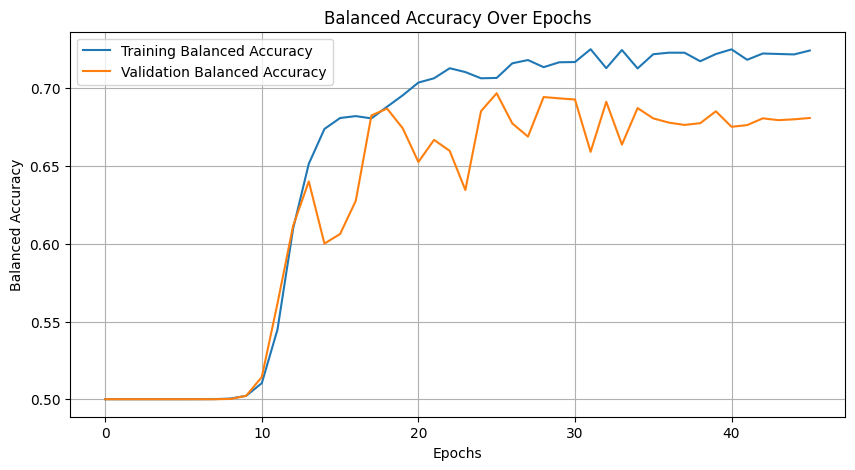

In [195]:
import matplotlib.pyplot as plt

# Extract metrics from history
val_balanced_accuracy = history.history.get('val_balanced_accuracy', [])
train_balanced_accuracy = history.history.get('balanced_accuracy', [])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_balanced_accuracy, label='Training Balanced Accuracy')
plt.plot(val_balanced_accuracy, label='Validation Balanced Accuracy')
plt.title('Balanced Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Balanced Accuracy')
plt.legend()
plt.grid()
plt.show()
